<a href="https://colab.research.google.com/github/upjabir/nlp_task/blob/main/tmlc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/ecommerce/ecommerceDataset.csv',header=None)
df.columns = ['class','text']

In [4]:
df.head()

,class,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [5]:
df['text'][0]

'Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal blis

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   50425 non-null  object
 1   text    50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [7]:
# checking sum of nan values
df.isna().sum()

class    0
text     1
dtype: int64

In [8]:
# drop nan values
df.dropna(inplace=True)

In [9]:
# exporing duplicated values in df
df[df.duplicated()]

,class,text
7,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
11,Household,Paper Plane Design Starry Night Vangoh Wall Ar...
12,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
16,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
20,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
...,...,...
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou..."


In [10]:
# drop duplicates
df =df.drop_duplicates()

### EDA

In [11]:
print(f"Data {df.shape[0]} rows and {df.shape[1]} columns")

Data 27802 rows and 2 columns


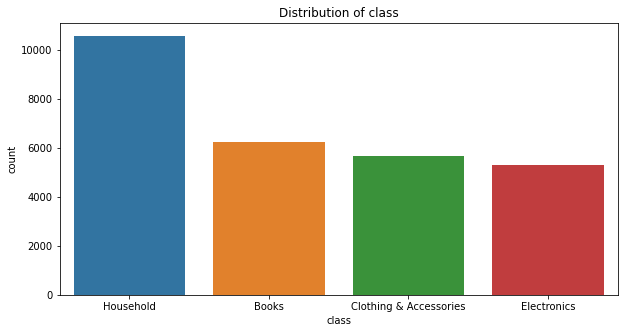

In [12]:
plt.figure(figsize=(10,5))
sns.countplot(x='class',data=df)
plt.title('Distribution of class')
plt.show()

House hold has more number describtion than other 3 classes. And also we can see that distribution between household and other 3 classes is not balanced.So we can try class balancing techniques.

Text(0.5, 1.0, 'Distribution of text length (number of words)')

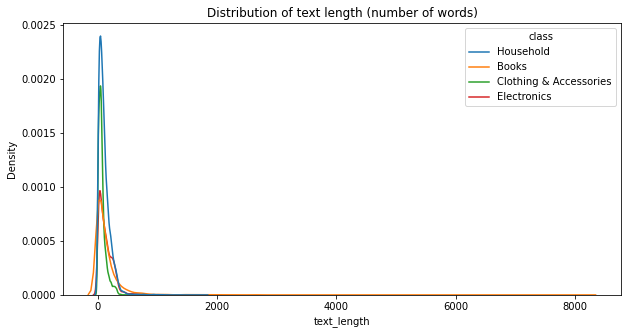

In [13]:
df_copy = df.copy()
df_copy['text_length'] = df_copy['text'].apply(lambda x: len(x.split(" ")))
plt.figure(figsize=(10,5))
sns.kdeplot(df_copy.text_length, hue=df_copy['class'], palette="tab10")
plt.title("Distribution of text length (number of words)")

In [14]:
df_copy['text_length'].describe()

count    27802.000000
mean       116.338105
std        169.523543
min          1.000000
25%         35.000000
50%         78.000000
75%        154.000000
max       8183.000000
Name: text_length, dtype: float64

In [15]:
np.quantile(df_copy['text_length'].tolist(), .95)

317.0

95% of text tength is 317 . So we can use max text length aroung 350.

In [18]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [19]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

df['cleaned_text'] = df['text'].apply(clean_text)

In [20]:
df.head()

,class,text,cleaned_text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...,paper plane design framed wall hanging motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ...",saf floral framed painting wood 30 inch 10 inc...
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...,saf uv tetured modern art print framed paintin...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1...",saf flower print framed painting synthetic 135...
4,Household,Incredible Gifts India Wooden Happy Birthday U...,incredible gifts india wooden happy birthday u...


In [21]:
print(df['text'][0])

Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal bliss

In [22]:
# label encoding target values
label_encoder = preprocessing.LabelEncoder()
df['labeled_class']= label_encoder.fit_transform(df['class'])

In [23]:
df['labeled_class'].unique()

array([3, 0, 1, 2])

In [24]:
X = df['cleaned_text']
y = df['labeled_class']

In [25]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state =42 , stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio) , random_state =42 , stratify=y_test) 

print(x_train.shape, x_val.shape, x_test.shape)

(20851,) (4170,) (2781,)


In [26]:
# TFID Vectorizer
tfidf_vectorizer = TfidfVectorizer() 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(x_train)
tfidf_test_vectors = tfidf_vectorizer.transform(x_test)
tfidf_val_vectors = tfidf_vectorizer.transform(x_val)

###  Base line Model 
##### Naive Bayes

In [27]:
multi_NB = MultinomialNB().fit(tfidf_train_vectors, y_train)
y_pred_NB=multi_NB.predict(tfidf_test_vectors)

In [28]:
accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred_NB)
print("accuracy is :",accuracy)
classification_report = metrics.classification_report(y_test, y_pred_NB)
print(classification_report)

accuracy is : 0.9187342682488313
              precision    recall  f1-score   support

           0       0.97      0.87      0.92       626
           1       0.98      0.93      0.95       568
           2       0.96      0.84      0.89       531
           3       0.85      0.98      0.91      1056

    accuracy                           0.92      2781
   macro avg       0.94      0.91      0.92      2781
weighted avg       0.92      0.92      0.92      2781



In [29]:
def model_evaluation(alpha ,name , classifier,myTable):
  cv_f1_score = []
  for i in alpha:
      print("for alpha =", i)
      clf = classifier(alpha=i)
      clf.fit(tfidf_train_vectors, y_train)
      y_predicted = clf.predict(tfidf_val_vectors)
      f1_score = metrics.f1_score(y_val, y_predicted, average='micro')
      accuracy = metrics.accuracy_score(y_val, y_predicted)
      cv_f1_score.append(f1_score)
      print("Accuracy :",accuracy) 

  fig, ax = plt.subplots()
  ax.plot(np.log10(alpha), cv_f1_score,c='g')
  for i, txt in enumerate(np.round(cv_f1_score,3)):
      ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_f1_score[i]))
  plt.grid()
  plt.xticks(np.log10(alpha))
  plt.title("Cross Validation Error for each alpha")
  plt.xlabel("Alpha i's")
  plt.ylabel("Error measure")
  plt.show()

  best_alpha = np.argmax(cv_f1_score)
  print(" The best Alpha is :",alpha[best_alpha])
  clf = classifier(alpha=alpha[best_alpha])
  clf.fit(tfidf_train_vectors, y_train)

  predict_y = clf.predict(tfidf_train_vectors)
  print('For values of best alpha = ', alpha[best_alpha], "The train f1 score is:",metrics.f1_score(y_train, predict_y, average='micro'))
  predict_y = clf.predict(tfidf_val_vectors)
  print('For values of best alpha = ', alpha[best_alpha], "The cross validation f1 score is:",metrics.f1_score(y_val, predict_y, average='micro'))
  predict_y = clf.predict(tfidf_test_vectors)
  test_f1_score = metrics.f1_score(y_test, predict_y, average='micro')
  print('For values of best alpha = ', alpha[best_alpha], "The test f1 score is:",test_f1_score)

  classification_report = metrics.classification_report(y_test, predict_y)
  print(classification_report)
  myTable.add_row([name,test_f1_score])

for alpha = 1e-05
Accuracy : 0.9417266187050359
for alpha = 0.0001
Accuracy : 0.9434052757793765
for alpha = 0.001
Accuracy : 0.943884892086331
for alpha = 0.1
Accuracy : 0.9434052757793765
for alpha = 1
Accuracy : 0.9179856115107914
for alpha = 10
Accuracy : 0.8270983213429257
for alpha = 100
Accuracy : 0.44916067146282973
for alpha = 1000
Accuracy : 0.3800959232613909


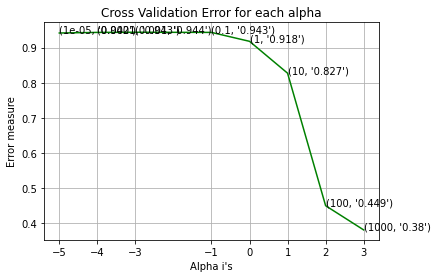

 The best Alpha is : 0.001
For values of best alpha =  0.001 The train f1 score is: 0.9818234137451441
For values of best alpha =  0.001 The cross validation f1 score is: 0.943884892086331
For values of best alpha =  0.001 The test f1 score is: 0.9475008989572097
              precision    recall  f1-score   support

           0       0.96      0.91      0.94       626
           1       0.98      0.96      0.97       568
           2       0.93      0.95      0.94       531
           3       0.93      0.96      0.95      1056

    accuracy                           0.95      2781
   macro avg       0.95      0.95      0.95      2781
weighted avg       0.95      0.95      0.95      2781



In [30]:
from prettytable import PrettyTable
myTable = PrettyTable(["Model", "F1-SCORE"])

model_evaluation([0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000],"NB Hyper Tuning" ,MultinomialNB , myTable)

### Hyper Parameter Tuned SGDC (log loss)

for alpha = 1e-06
Accuracy : 0.9556354916067147
for alpha = 1e-05
Accuracy : 0.9544364508393285
for alpha = 0.0001
Accuracy : 0.9436450839328537
for alpha = 0.001
Accuracy : 0.9302158273381295
for alpha = 0.01
Accuracy : 0.750599520383693
for alpha = 0.1
Accuracy : 0.4143884892086331
for alpha = 1
Accuracy : 0.40335731414868103
for alpha = 10
Accuracy : 0.1908872901678657
for alpha = 100
Accuracy : 0.1908872901678657


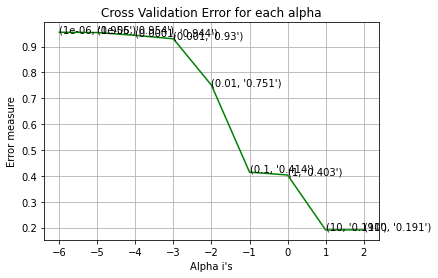

 The best Alpha is : 1e-06
For values of best alpha =  1e-06 The train f1 score is: 0.9990887727207328
For values of best alpha =  1e-06 The cross validation f1 score is: 0.9556354916067147
For values of best alpha =  1e-06 The test f1 score is: 0.9590075512405609
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       626
           1       0.98      0.98      0.98       568
           2       0.95      0.95      0.95       531
           3       0.95      0.97      0.96      1056

    accuracy                           0.96      2781
   macro avg       0.96      0.96      0.96      2781
weighted avg       0.96      0.96      0.96      2781



In [32]:
# SGDC log loss (Logistic )
alpha = [10 ** x for x in range(-6, 3)]
cv_f1_score = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(tfidf_train_vectors, y_train)
    y_predicted = clf.predict(tfidf_val_vectors)
    f1_score = metrics.f1_score(y_val, y_predicted, average='micro')
    accuracy = metrics.accuracy_score(y_val, y_predicted)
    cv_f1_score.append(f1_score)
    print("Accuracy :",accuracy) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_f1_score,c='g')
for i, txt in enumerate(np.round(cv_f1_score,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_f1_score[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmax(cv_f1_score)
print(" The best Alpha is :",alpha[best_alpha])
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(tfidf_train_vectors, y_train)

predict_y = clf.predict(tfidf_train_vectors)
print('For values of best alpha = ', alpha[best_alpha], "The train f1 score is:",metrics.f1_score(y_train, predict_y, average='micro'))
predict_y = clf.predict(tfidf_val_vectors)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation f1 score is:",metrics.f1_score(y_val, predict_y, average='micro'))
predict_y = clf.predict(tfidf_test_vectors)
test_f1_score = metrics.f1_score(y_test, predict_y, average='micro')
print('For values of best alpha = ', alpha[best_alpha], "The test f1 score is:",test_f1_score)

classification_report = metrics.classification_report(y_test, predict_y)
print(classification_report)
myTable.add_row(["SGDC log loss",test_f1_score])

### Hyper Parameter Tuned SGDC (hinge loss)

for alpha = 1e-05
Accuracy : 0.9556354916067147
for alpha = 0.0001
Accuracy : 0.9541966426858514
for alpha = 0.001
Accuracy : 0.9378896882494004
for alpha = 0.01
Accuracy : 0.9179856115107914
for alpha = 0.1
Accuracy : 0.3800959232613909
for alpha = 1
Accuracy : 0.39688249400479614
for alpha = 10
Accuracy : 0.1908872901678657
for alpha = 100
Accuracy : 0.1908872901678657


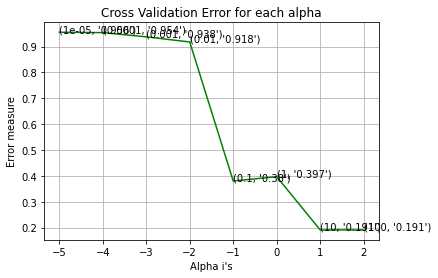

 The best Alpha is : 1e-05
For values of best alpha =  1e-05 The train f1 score is: 0.9973142774926862
For values of best alpha =  1e-05 The cross validation f1 score is: 0.9556354916067147
For values of best alpha =  1e-05 The test f1 score is: 0.9582883854728514
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       626
           1       0.98      0.98      0.98       568
           2       0.95      0.95      0.95       531
           3       0.95      0.97      0.96      1056

    accuracy                           0.96      2781
   macro avg       0.96      0.96      0.96      2781
weighted avg       0.96      0.96      0.96      2781



In [33]:
# SGDC hinge loss (Linear SVM)


alpha = [10 ** x for x in range(-5, 3)]
cv_f1_score = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(tfidf_train_vectors, y_train)
    y_predicted = clf.predict(tfidf_val_vectors)
    f1_score = metrics.f1_score(y_val, y_predicted, average='micro')
    accuracy = metrics.accuracy_score(y_val, y_predicted)
    cv_f1_score.append(f1_score)
    print("Accuracy :",accuracy) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_f1_score,c='g')
for i, txt in enumerate(np.round(cv_f1_score,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_f1_score[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmax(cv_f1_score)
print(" The best Alpha is :",alpha[best_alpha])
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(tfidf_train_vectors, y_train)

predict_y = clf.predict(tfidf_train_vectors)
print('For values of best alpha = ', alpha[best_alpha], "The train f1 score is:",metrics.f1_score(y_train, predict_y, average='micro'))
predict_y = clf.predict(tfidf_val_vectors)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation f1 score is:",metrics.f1_score(y_val, predict_y, average='micro'))
predict_y = clf.predict(tfidf_test_vectors)
test_f1_score = metrics.f1_score(y_test, predict_y, average='micro')
print('For values of best alpha = ', alpha[best_alpha], "The test f1 score is:",test_f1_score)

classification_report = metrics.classification_report(y_test, predict_y)
print(classification_report)
myTable.add_row(["SGDC Hinge loss",test_f1_score])

### Hyper Parameter Tuned RF

In [34]:
# Random Forest
alpha = [100,200,500,1000,2000]
max_depth = [20,40,60]
for i in alpha:
  for j in max_depth:
    print("for n_estimators =", i,"and max depth = ", j)
    clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42)
    clf.fit(tfidf_train_vectors, y_train)
    y_predicted = clf.predict(tfidf_val_vectors)
    f1_score = metrics.f1_score(y_val, y_predicted, average='micro')
    print("The value of alpha: %f , max depth :%f , F1 Score : %0.3f" % (i,j,f1_score)) 

for n_estimators = 100 and max depth =  20
The value of alpha: 100.000000 , max depth :20.000000 , F1 Score : 0.732
for n_estimators = 100 and max depth =  40
The value of alpha: 100.000000 , max depth :40.000000 , F1 Score : 0.854
for n_estimators = 100 and max depth =  60
The value of alpha: 100.000000 , max depth :60.000000 , F1 Score : 0.896
for n_estimators = 200 and max depth =  20
The value of alpha: 200.000000 , max depth :20.000000 , F1 Score : 0.737
for n_estimators = 200 and max depth =  40
The value of alpha: 200.000000 , max depth :40.000000 , F1 Score : 0.858
for n_estimators = 200 and max depth =  60
The value of alpha: 200.000000 , max depth :60.000000 , F1 Score : 0.899
for n_estimators = 500 and max depth =  20
The value of alpha: 500.000000 , max depth :20.000000 , F1 Score : 0.737
for n_estimators = 500 and max depth =  40
The value of alpha: 500.000000 , max depth :40.000000 , F1 Score : 0.864
for n_estimators = 500 and max depth =  60
The value of alpha: 500.00000

In [35]:
clf = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=60, random_state=42)
clf.fit(tfidf_train_vectors, y_train)

RandomForestClassifier(max_depth=60, n_estimators=500, random_state=42)

In [36]:
predict_y = clf.predict(tfidf_train_vectors)
print( "The train f1 score is:",metrics.f1_score(y_train, predict_y, average='micro'))
predict_y = clf.predict(tfidf_val_vectors)
print( "The cross validation f1 score is:",metrics.f1_score(y_val, predict_y, average='micro'))
predict_y = clf.predict(tfidf_test_vectors)
test_f1_score = metrics.f1_score(y_test, predict_y, average='micro')
print("The test f1 score is:",test_f1_score)

classification_report = metrics.classification_report(y_test, predict_y)
print(classification_report)
myTable.add_row(["Random Forest",test_f1_score])


The train f1 score is: 0.9535753680878615
The cross validation f1 score is: 0.9019184652278177
The test f1 score is: 0.8946422150305645
              precision    recall  f1-score   support

           0       0.97      0.79      0.87       626
           1       0.96      0.94      0.95       568
           2       0.96      0.81      0.88       531
           3       0.81      0.97      0.88      1056

    accuracy                           0.89      2781
   macro avg       0.93      0.88      0.90      2781
weighted avg       0.91      0.89      0.89      2781



### Stacked Classifier

In [37]:
nb_best = MultinomialNB(alpha=0.001) 
nb_best.fit(tfidf_train_vectors, y_train)

sgdc_log = SGDClassifier(class_weight='balanced', alpha=1e-06, penalty='l2', loss='log', random_state=42)
sgdc_log.fit(tfidf_train_vectors, y_train)

sgdc_svm = SGDClassifier(class_weight='balanced', alpha=1e-05, penalty='l2', loss='hinge', random_state=42)
sgdc_svm.fit(tfidf_train_vectors, y_train)

alpha = [0.0001,0.001,0.01,0.1,1,10,15] 
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sgdc_log, nb_best, sgdc_svm], meta_classifier=lr)
    sclf.fit(tfidf_train_vectors, y_train)
    y_preds = sclf.predict(tfidf_val_vectors)
    print("Stacking Classifer : for the value of alpha: %f F1 Score : %0.3f" % (i, metrics.f1_score(y_val, y_preds, average='micro')))

Stacking Classifer : for the value of alpha: 0.000100 F1 Score : 0.586
Stacking Classifer : for the value of alpha: 0.001000 F1 Score : 0.944
Stacking Classifer : for the value of alpha: 0.010000 F1 Score : 0.951
Stacking Classifer : for the value of alpha: 0.100000 F1 Score : 0.955
Stacking Classifer : for the value of alpha: 1.000000 F1 Score : 0.955
Stacking Classifer : for the value of alpha: 10.000000 F1 Score : 0.956
Stacking Classifer : for the value of alpha: 15.000000 F1 Score : 0.956


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [38]:
lr = LogisticRegression(C=10)
sclf = StackingClassifier(classifiers=[sgdc_log, nb_best, sgdc_svm], meta_classifier=lr)
sclf.fit(tfidf_train_vectors, y_train)

predict_y = sclf.predict(tfidf_train_vectors)
print( "The train f1 score is:",metrics.f1_score(y_train, predict_y, average='micro'))
predict_y = sclf.predict(tfidf_val_vectors)
print( "The cross validation f1 score is:",metrics.f1_score(y_val, predict_y, average='micro'))
predict_y = sclf.predict(tfidf_test_vectors)
test_f1_score = metrics.f1_score(y_test, predict_y, average='micro')
print("The test f1 score is:",test_f1_score)

classification_report = metrics.classification_report(y_test, predict_y)
print(classification_report)
myTable.add_row(["Stacked Classifier",test_f1_score])

The train f1 score is: 0.9990408133902451
The cross validation f1 score is: 0.9556354916067147
The test f1 score is: 0.9579288025889967
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       626
           1       0.98      0.98      0.98       568
           2       0.94      0.95      0.94       531
           3       0.95      0.97      0.96      1056

    accuracy                           0.96      2781
   macro avg       0.96      0.96      0.96      2781
weighted avg       0.96      0.96      0.96      2781



In [39]:
print(myTable)

+--------------------+--------------------+
|       Model        |      F1-SCORE      |
+--------------------+--------------------+
|  NB Hyper Tuning   | 0.9475008989572097 |
|   SGDC log loss    | 0.9590075512405609 |
|  SGDC Hinge loss   | 0.9582883854728514 |
|   Random Forest    | 0.8946422150305645 |
| Stacked Classifier | 0.9579288025889967 |
+--------------------+--------------------+


### LSTM

In [42]:
# The maximum number of words to be used.
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 350
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['cleaned_text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 106500 unique tokens.


In [43]:
X = tokenizer.texts_to_sequences(df['cleaned_text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

Y = pd.get_dummies(df['class'].values)
print('Shape of data tensor:', X.shape ,Y.shape)

Shape of data tensor: (27802, 350) (27802, 4)


In [44]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)

(25021, 350) (25021, 4)


In [45]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 350, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 350, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 4)                 404       
                                                                 
Total params: 5,080,804
Trainable params: 5,080,804
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
epochs = 25
batch_size = 64
patience =5
early_stopping = EarlyStopping(
                    monitor='val_loss',
                    min_delta=0,
                    patience=patience,
                    verbose=1,
                    mode='auto',
                    restore_best_weights=True
                )

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[early_stopping])

Epoch 1/25
352/352 [==============================] - 478s 1s/step - loss: 0.0964 - accuracy: 0.9759 - val_loss: 0.2180 - val_accuracy: 0.9449
Epoch 2/25
352/352 [==============================] - 475s 1s/step - loss: 0.0725 - accuracy: 0.9824 - val_loss: 0.2720 - val_accuracy: 0.9349
Epoch 3/25
352/352 [==============================] - 476s 1s/step - loss: 0.0525 - accuracy: 0.9873 - val_loss: 0.2631 - val_accuracy: 0.9377
Epoch 4/25
352/352 [==============================] - 480s 1s/step - loss: 0.0427 - accuracy: 0.9901 - val_loss: 0.2922 - val_accuracy: 0.9321
Epoch 5/25
352/352 [==============================] - 479s 1s/step - loss: 0.0388 - accuracy: 0.9912 - val_loss: 0.2773 - val_accuracy: 0.9453
Epoch 6/25
352/352 [==============================] - 478s 1s/step - loss: 0.0339 - accuracy: 0.9914 - val_loss: 0.3327 - val_accuracy: 0.9425
Epoch 6: early stopping


In [53]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
myTable.add_row(["LSTM",accr[1]])

87/87 [==============================] - 12s 142ms/step - loss: 0.2127 - accuracy: 0.9479
Test set
  Loss: 0.213
  Accuracy: 0.948


In [54]:
print(myTable)

+--------------------+--------------------+
|       Model        |      F1-SCORE      |
+--------------------+--------------------+
|  NB Hyper Tuning   | 0.9475008989572097 |
|   SGDC log loss    | 0.9590075512405609 |
|  SGDC Hinge loss   | 0.9582883854728514 |
|   Random Forest    | 0.8946422150305645 |
| Stacked Classifier | 0.9579288025889967 |
|        LSTM        | 0.9478604793548584 |
+--------------------+--------------------+


1. From the results , we can see SGD Classifier with log loss have high F1 Score compare to others.
2. We can also experiment with other embedding techiques such as word2vec , glove etc
3. Also we can try modern state of art architecture such as bert, roberta etc.